In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sub = pd.read_csv('sample_submission.csv')

In [3]:
train.head()

,Lunation Number,Date of occurrence,Day of Month,Time of occurrence,Time Difference,Angle of Rays,Eclipse Type 1,Gamma,Magnitude 1,Latitude,Longitude,Eclipse Duration (m)
0,LN-49456,2023-06,26,14:13:28,46437,17,N,-1.0981,0.8791,24S,22W,278.53620
1,LN-49451,2022-11,21,20:23:49,46427,-16,N,-1.1155,0.8143,15N,98W,241.84410
2,LN-49445,2020-05,17,05:47:36,46416,-11,P,0.8988,1.2105,13S,89E,291.90705
3,LN-49439,2025-11,11,05:15:58,46404,-6,P,-0.4644,2.0382,12N,113E,355.85910
4,LN-49433,2024-05,6,18:57:01,46392,-1,T+,0.1003,2.6513,11S,92W,334.50720


In [4]:
test.head()

,ID,Lunation Number,Date of occurrence,Day of Month,Time of occurrence,Time Difference,Angle of Rays,Eclipse Type 1,Gamma,Magnitude 1,Latitude,Longitude
0,1,LN-187710,2024-09,10,19:22:54,25953,47,A,0.4175,0.9677,32.5N,5.5E
1,2,LN-187685,2021-02,6,14:13:01,25946,14,Pe,1.5329,0.0444,69.2N,50.9E
2,3,LN-187680,2023-03,8,03:29:08,25944,52,P,-1.2696,0.5008,71.1S,3.2W
3,4,LN-187655,2023-08,1,20:01:21,25937,19,Pe,-1.5079,0.0469,68.2S,29.4W
4,5,LN-187650,2023-08,31,05:18:35,25936,57,P,1.1064,0.8027,70.7N,21.4W


In [5]:
sub.head()

,ID,Eclipse Duration (m)
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


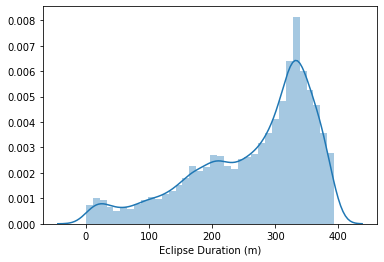

In [6]:
tar = 'Eclipse Duration (m)'
sns.distplot(train[tar])

In [7]:
train['Eclipse Duration (m)'].describe()

count    14377.000000
mean       264.878573
std         95.007394
min         -0.075000
25%        203.389950
50%        295.016550
75%        337.616700
max        393.276750
Name: Eclipse Duration (m), dtype: float64

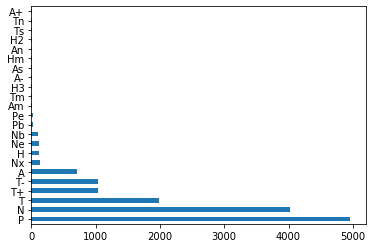

In [8]:
train['Eclipse Type 1'].value_counts().plot(kind='barh')

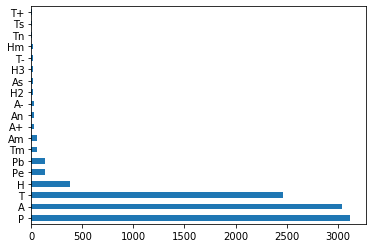

In [9]:
test['Eclipse Type 1'].value_counts().plot(kind='barh')

In [10]:
test['Eclipse Type 1']. nunique() == train['Eclipse Type 1'].nunique()

False

In [11]:
train['Eclipse Type 1'].nunique()

23

In [12]:
test['Eclipse Type 1']. nunique()

19

In [13]:
train.isnull().sum()

Lunation Number         0
Date of occurrence      0
Day of Month            0
Time of occurrence      0
Time Difference         0
Angle of Rays           0
Eclipse Type 1          0
Gamma                   0
Magnitude 1             0
Latitude                0
Longitude               0
Eclipse Duration (m)    0
dtype: int64

In [14]:
from sklearn.preprocessing import LabelEncoder

In [15]:
def preproc(df):
    t = df.copy()
    t['S'] = t['Longitude'].str.contains('W')
    t['W'] = t['Latitude'].str.contains('S')
    t['lon'] = t['Longitude'].apply(lambda x: float(x[:-1]))
    t['lan'] = t['Latitude'].apply(lambda x: float(x[:-1]))
    t.drop(['Longitude', 'Latitude', 'Time of occurrence', 'Date of occurrence', 'Lunation Number'], axis=1, inplace=True)
    print(t.info())
    return t

In [16]:
trn, tes = preproc(train), preproc(test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14377 entries, 0 to 14376
Data columns (total 11 columns):
Day of Month            14377 non-null int64
Time Difference         14377 non-null int64
Angle of Rays           14377 non-null int64
Eclipse Type 1          14377 non-null object
Gamma                   14377 non-null float64
Magnitude 1             14377 non-null float64
Eclipse Duration (m)    14377 non-null float64
S                       14377 non-null bool
W                       14377 non-null bool
lon                     14377 non-null float64
lan                     14377 non-null float64
dtypes: bool(2), float64(5), int64(3), object(1)
memory usage: 1.0+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9585 entries, 0 to 9584
Data columns (total 11 columns):
ID                 9585 non-null int64
Day of Month       9585 non-null int64
Time Difference    9585 non-null int64
Angle of Rays      9585 non-null int64
Eclipse Type 1     9585 non-null object
Gamma   

In [17]:
le = LabelEncoder()
le.fit(trn['Eclipse Type 1'])
trn['Eclipse Type 1'] = le.transform(trn['Eclipse Type 1'])
tes['Eclipse Type 1'] = le.transform(tes['Eclipse Type 1'])

In [18]:
tes.drop(['ID'], axis=1, inplace=True)

In [19]:
X = trn.drop([tar], axis=1)
y = trn[tar]

In [20]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, KFold
from lightgbm.sklearn import LGBMRegressor
from sklearn.linear_model import ElasticNet, Lasso, Ridge
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

# Model Stacking

In [41]:
def show_cv(clf):
    scores = cross_val_score(clf, X, y, cv=5, scoring='neg_mean_squared_error')
    print(f"MSE scores : {-1*scores.mean():.2f} +/- {scores.std():.2f}")

In [44]:
seed = 2019

rf = RandomForestRegressor(n_estimators=100, random_state=seed)

lasso = Lasso()

lightgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=25,
                                       learning_rate=0.01, 
                                       n_estimators=5000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=1,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       #min_data_in_leaf=2,
                                       #min_sum_hessian_in_leaf=11
                                       )

stack = StackingCVRegressor(regressors=(lasso, rf, lightgbm), meta_regressor=lasso, use_features_in_secondary=True,
                           random_state=True)

In [45]:
for clf, label in zip([lasso, rf, lightgbm, stack], ['Lasso', 'RandomForest', 'Lightgbm', 'Stacking']):
    print(f'{label}')
    show_cv(clf)

Lasso
MSE scores : 5176.36 +/- 7166.61
RandomForest
MSE scores : 3220.11 +/- 5588.29
Lightgbm
MSE scores : 3643.23 +/- 5488.64
Stacking
MSE scores : 3330.48 +/- 5538.58


# RandomForest + KFolds

In [46]:
from sklearn.metrics import mean_squared_error

In [47]:
def kfold_model(clf, k=5):
    cv = KFold(n_splits=k, random_state=seed, shuffle=True)
    oof = np.zeros((tes.shape[0], k))
    scores = []
    for i, (trn_idx, tes_idx) in enumerate(cv.split(X)):
        xtrn, xtes, ytrn, ytes = X.iloc[trn_idx], X.iloc[tes_idx], y[trn_idx], y[tes_idx]
        clf.fit(xtrn, ytrn)
        score = mean_squared_error(clf.predict(xtes), ytes)
        scores.append(score)
        oof[:, i] = clf.predict(tes)
    preds = np.mean(oof, axis=1)
    print(np.sqrt(np.mean(scores)))
    return preds

In [48]:
preds = kfold_model(RandomForestRegressor(n_estimators=10, random_state=seed))

31.73997306375219


In [49]:
preds = kfold_model(RandomForestRegressor(n_estimators=25, random_state=seed))

30.558201961941162


In [50]:
preds = kfold_model(RandomForestRegressor(n_estimators=50, random_state=seed))

30.558051126235522


In [51]:
sub[tar] = preds
sub.to_csv('rf_5folds_sub.csv', index=False)

# LGBM + KFolds

In [52]:
lightgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.01, 
                                       n_estimators=5000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=1,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       #min_data_in_leaf=2,
                                       #min_sum_hessian_in_leaf=11
                                       )

In [53]:
preds = kfold_model(lightgbm, 10)

41.73499496353049


In [54]:
sub[tar] = preds
sub.to_csv('lgbm_10folds.csv', index=False)

# Stacking + KFold

In [ ]:
preds = kfold_model(stack)

In [ ]:
sub[tar] = preds
sub.to_csv('stacking_5folds.csv', index=False)

# Lasso + KFold

In [ ]:
preds = kfold_model(lasso)

In [ ]:
sub[tar] = preds
sub.to_csv('lasso_5folds.csv', index=False)